# EDA - Transit Cost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [64]:
%load_ext autoreload
%autoreload 2

In [65]:
from config import CONFIG

### Data Dictionary

# `transit_cost.csv`

|variable         |class     |description |
|:----------------|:---------|:-----------|
|e                |double    | ID |
|country          |character | Country Code - can be joined against `countrycode` via `ecb` or `iso2c` |
|city             |character | City where transit tunnel is being created |
|line             |character | Line name or path |
|start_year       |character | Year started |
|end_year         |character | Year ended (predicted or actual) |
|rr               |double    | I think this is Railroad (0 or 1), where 1 == Railroad? |
|length           |double    | Length of proposed line in km |
|tunnel_per       |character | Percent of line length completed |
|tunnel           |double    | Tunnel length of line completed in km (can take this divided by length to get `tunnel_per`) |
|stations         |double    | Number of stations where passengers can board/leave |
|source1          |character | Where was data sourced |
|cost             |double    | Cost in millions of local currency |
|currency         |character | Currency type |
|year             |double    | Midpoint year of construction |
|ppp_rate         |double    | purchasing power parity (PPP), based on the midpoint of construction |
|real_cost        |character | Real cost in Millions of USD |
|cost_km_millions |double    | Cost/km in millions of USD |
|source2          |character | Where was data sourced for cost |
|reference        |character | Reference URL for source |

In [2]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-05/transit_cost.csv"

df = pd.read_csv(url)
df.head()


,e,country,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,source1,cost,currency,year,ppp_rate,real_cost,cost_km_millions,source2,reference
0,7136.0,CA,Vancouver,Broadway,2020,2025,0.0,5.7,87.72%,5.0,6.0,Plan,2830.0,CAD,2018.0,0.84,2377.2,417.052632,Media,https://www.translink.ca/Plans-and-Projects/Ra...
1,7137.0,CA,Toronto,Vaughan,2009,2017,0.0,8.6,100.00%,8.6,6.0,Media,3200.0,CAD,2013.0,0.81,2592,301.395349,Media,https://www.thestar.com/news/gta/transportatio...
2,7138.0,CA,Toronto,Scarborough,2020,2030,0.0,7.8,100.00%,7.8,3.0,Wiki,5500.0,CAD,2018.0,0.84,4620,592.307692,Media,https://urbantoronto.ca/news/2020/03/metrolinx...
3,7139.0,CA,Toronto,Ontario,2020,2030,0.0,15.5,57.00%,8.8,15.0,Plan,8573.0,CAD,2019.0,0.84,7201.32,464.601290,Plan,https://metrolinx.files.wordpress.com/2019/07/...
4,7144.0,CA,Toronto,Yonge to Richmond Hill,2020,2030,0.0,7.4,100.00%,7.4,6.0,Plan,5600.0,CAD,2020.0,0.84,4704,635.675676,Media,https://www.thestar.com/news/gta/2020/06/24/me...


In [17]:
df.shape

(544, 20)

From the first glance, we don't need <span style="color:red">*source1, source2 and reference*</span> as they are not important to our data analysis. We'll drop these variables. *year* variable is not clear. We'll also drop it. We'll analyze these projects in us currency so <span style="color:red">*cost* and *currentcy*</span> we'll be eliminated. If we know which city the project was built in, we'll know that country too. Hence, we'll drop <span style="color:red">*country*</span> from our table. 

In [24]:
vars_to_drop = ["source1", "source2", "reference", "year", "cost", "country", "currency"]
df1 = df.loc[:,[x for x in df.columns if x not in vars_to_drop]]
df1.head()

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
0,7136.0,Vancouver,Broadway,2020,2025,0.0,5.7,87.72%,5.0,6.0,0.84,2377.2,417.052632
1,7137.0,Toronto,Vaughan,2009,2017,0.0,8.6,100.00%,8.6,6.0,0.81,2592,301.395349
2,7138.0,Toronto,Scarborough,2020,2030,0.0,7.8,100.00%,7.8,3.0,0.84,4620,592.307692
3,7139.0,Toronto,Ontario,2020,2030,0.0,15.5,57.00%,8.8,15.0,0.84,7201.32,464.601290
4,7144.0,Toronto,Yonge to Richmond Hill,2020,2030,0.0,7.4,100.00%,7.4,6.0,0.84,4704,635.675676


In [25]:
df1.tail(10)

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
534,9510.0,Istanbul,M11 Phase 2,2019,2022,0.0,32.000000,100.00%,32.0000,7.0,3.7,3389.2,105.910000
535,9459.0,Tashkent,Sergeli Line,2017,2020,0.0,7.100000,0.00%,7.1000,6.0,5.0,711,100.140845
536,9460.0,Tashkent,Yunusabad Line extension,2017,2020,0.0,2.900000,100.00%,2.9000,2.0,5.0,624,215.172414
537,NaN,NaN,NaN,NaN,NaN,NaN,12256.983000,NaN,7790.7826,NaN,NaN,AVG,233.079919
538,NaN,NaN,NaN,NaN,NaN,NaN,7660.614375,NaN,NaN,NaN,NaN,MEDIAN,180.702862
539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STD,258.744889
540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIN,7.789626
541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 1,134.863267
542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 3,241.428571
543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,567.000000


In [26]:
df2 = df1.iloc[:-7,:]
df2.tail()

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
532,9508.0,Istanbul,M12,2017,2022,0.0,13.0,100.00%,13.0,9.0,3.7,3411.4,262.420000
533,9509.0,Istanbul,M11 Phase 1,2016,2021,0.0,37.5,100.00%,37.5,9.0,3.1,3503,93.410000
534,9510.0,Istanbul,M11 Phase 2,2019,2022,0.0,32.0,100.00%,32.0,7.0,3.7,3389.2,105.910000
535,9459.0,Tashkent,Sergeli Line,2017,2020,0.0,7.1,0.00%,7.1,6.0,5.0,711,100.140845
536,9460.0,Tashkent,Yunusabad Line extension,2017,2020,0.0,2.9,100.00%,2.9,2.0,5.0,624,215.172414


### Handling Missing Values


In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   e                 537 non-null    float64
 1   city              537 non-null    object 
 2   line              537 non-null    object 
 3   start_year        491 non-null    object 
 4   end_year          473 non-null    object 
 5   rr                536 non-null    float64
 6   length            537 non-null    float64
 7   tunnel_per        512 non-null    object 
 8   tunnel            511 non-null    float64
 9   stations          529 non-null    float64
 10  ppp_rate          535 non-null    float64
 11  real_cost         537 non-null    object 
 12  cost_km_millions  535 non-null    float64
dtypes: float64(7), object(6)
memory usage: 54.7+ KB


In [35]:
df2.loc[df2.start_year.isnull(),:]

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
119,7376.0,Tehran,Line 6,NaN,2020,0.0,31.000,100.00%,31.000,29.0,0.000064,5760,185.806452
120,7377.0,Tehran,Line 7,NaN,2019,0.0,27.000,100.00%,27.000,25.0,0.000064,5760,213.333333
204,7545.0,Nagpur,Phase 2,NaN,NaN,0.0,43.800,0.00%,0.000,32.0,0.048000,5383.68,122.915069
271,7712.0,Shenzhen,Line 3 Phase 4,NaN,2022,0.0,9.350,79.36%,7.420,7.0,0.238200,2568.99,274.760000
277,7722.0,Shenzhen,Line 8 Phase 3,NaN,2025,0.0,4.260,100.00%,4.260,NaN,0.238200,1981.35,465.110000
292,7754.0,Shanghai,Line 1 Western Extension,NaN,NaN,0.0,1.200,0.00%,0.000,1.0,0.237900,850.38,708.650000
293,7755.0,Shanghai,Line 20 Phase 1,NaN,NaN,0.0,19.800,100.00%,19.800,16.0,0.237900,9361.08,472.780000
295,7761.0,Wuhan,Line 11 Phase 3,NaN,NaN,0.0,9.900,100.00%,9.900,6.0,0.238200,3219.39,325.190000
296,7762.0,Shanghai,Line 19,NaN,NaN,0.0,44.500,100.00%,44.500,32.0,0.237900,14396.76,323.520000
297,7763.0,Shanghai,Line 21 Phase 1,NaN,NaN,0.0,28.000,100.00%,28.000,16.0,0.237900,8790.68,313.950000


In [36]:
df2.loc[df2.end_year.isnull(),:]

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
21,7177.0,Sofia,Line 3 extension (Third Stage),2021,NaN,0.0,3.100,100.00%,3.1,4.0,3.320000,373.5,120.483871
153,7442.0,Hamburg,U4 to Dannerallee,2020,NaN,0.0,2.600,100.00%,2.6,3.0,1.300000,664.3,255.500000
174,7483.0,Bangkok,Brown Line,2020,NaN,0.0,22.100,0.00%,0.0,18.0,0.081000,3919.266,177.342353
204,7545.0,Nagpur,Phase 2,NaN,NaN,0.0,43.800,0.00%,0.0,32.0,0.048000,5383.68,122.915069
207,7552.0,Hyderabad,Airport express,2020,NaN,0.0,31.000,8.00%,2.5,10.0,0.047000,2185.5,70.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,8138.0,Changchun,Line 3 Southern Extension,NaN,NaN,0.0,3.000,26.67%,0.8,2.0,0.237900,199.57,66.520000
484,8147.0,Wenzhou,S2 Phase 1,NaN,NaN,0.0,70.299,NaN,NaN,NaN,0.266000,6969.94,99.150000
501,8187.0,Mecca,Mecca Metro,2009,NaN,NaN,188.000,NaN,NaN,90.0,0.616143,38200.8626,203.196078
502,8192.0,Ad Dammam,Dammam Metro (a-Sharqiya),2014,NaN,0.0,50.000,0.00%,0.0,NaN,1.623000,25968,519.360000


Most of the missing start_year and end_year come from China. We'll remove these nan values from our data

In [44]:
df3.loc[df3.start_year.isnull(),:]

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
119,7376.0,Tehran,Line 6,NaN,2020,0.0,31.00,100.00%,31.00,29.0,0.000064,5760,185.806452
120,7377.0,Tehran,Line 7,NaN,2019,0.0,27.00,100.00%,27.00,25.0,0.000064,5760,213.333333
271,7712.0,Shenzhen,Line 3 Phase 4,NaN,2022,0.0,9.35,79.36%,7.42,7.0,0.238200,2568.99,274.760000
277,7722.0,Shenzhen,Line 8 Phase 3,NaN,2025,0.0,4.26,100.00%,4.26,NaN,0.238200,1981.35,465.110000
344,7858.0,Shanghai,Line 8 Phase 1,NaN,2009,0.0,23.22,100.00%,23.22,22.0,0.368300,5338.12,229.890000
413,8000.0,Suzhou,Line S1,NaN,2023,0.0,41.00,100.00%,41.00,27.0,0.237900,6510.47,158.790000
465,8105.0,Shanghai,Line 11 (to Disney),NaN,2016,0.0,9.15,15.96%,1.46,3.0,0.280800,1227.46,134.150000
473,8121.0,Chongqing,Line 6 Branch (EXPO) Phase 1,NaN,2013,0.0,12.20,NaN,NaN,6.0,0.272900,1444.32,118.390000


In [45]:
df3 = df2.loc[~(df2.start_year.isnull()) & ~(df2.end_year.isnull()), :]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 536
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   e                 465 non-null    float64
 1   city              465 non-null    object 
 2   line              465 non-null    object 
 3   start_year        465 non-null    object 
 4   end_year          465 non-null    object 
 5   rr                465 non-null    float64
 6   length            465 non-null    float64
 7   tunnel_per        445 non-null    object 
 8   tunnel            444 non-null    float64
 9   stations          460 non-null    float64
 10  ppp_rate          463 non-null    float64
 11  real_cost         465 non-null    object 
 12  cost_km_millions  463 non-null    float64
dtypes: float64(7), object(6)
memory usage: 50.9+ KB


Since e is just the ID variable, we'll eliminate it

In [46]:
df4 = df3.drop("e", axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 536
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              465 non-null    object 
 1   line              465 non-null    object 
 2   start_year        465 non-null    object 
 3   end_year          465 non-null    object 
 4   rr                465 non-null    float64
 5   length            465 non-null    float64
 6   tunnel_per        445 non-null    object 
 7   tunnel            444 non-null    float64
 8   stations          460 non-null    float64
 9   ppp_rate          463 non-null    float64
 10  real_cost         465 non-null    object 
 11  cost_km_millions  463 non-null    float64
dtypes: float64(6), object(6)
memory usage: 47.2+ KB


In [54]:
df4.loc[df4.stations.isnull(),:]

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
190,Tokyo,Monorail to Tokyo Station,2015,2025,1.0,3.00,0.00%,0.00,NaN,0.0100,1095,365.000000
336,Nanchang,Line 3,2015,2020,0.0,26.80,100.00%,26.80,NaN,0.2889,6370.99,237.720000
503,Doha,Doha Metro,2013,2026,0.0,124.00,89.92%,111.50,NaN,2.5000,90000,725.806452
505,Bahrain,Phase 2,2020,X,1.0,72.70,0.00%,0.00,NaN,5.0000,7500,103.163686
521,Shanghai,Line 16,2010,2014,0.0,58.96,23.22%,13.69,NaN,0.3004,5455.264,92.520000


We'll impute this variable with the median as it is an integer variable.

In [57]:
df5.loc[df5.ppp_rate.isnull(),:]

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
512,Cairo,Line 3 Phase 2,2009,2014,0.0,7.2,100.00%,7.2,4.0,NaN,0,NaN
513,Cairo,Line 3 Phase 3,2017,2022,0.0,11.6,100.00%,11.6,12.0,NaN,0,NaN


In [59]:
df5.loc[df5.real_cost == "0",:]

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
512,Cairo,Line 3 Phase 2,2009,2014,0.0,7.2,100.00%,7.2,4.0,NaN,0,NaN
513,Cairo,Line 3 Phase 3,2017,2022,0.0,11.6,100.00%,11.6,12.0,NaN,0,NaN


We'll drop the nan values of ppp_rate and cost_km_millions as they are related and since the real cost is 0, these data will create noise in our dataset.

In [62]:
df4.drop([512, 513], axis=0, inplace=True)


In [63]:
df5 = df4.fillna({"stations":"median"})
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 536
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              463 non-null    object 
 1   line              463 non-null    object 
 2   start_year        463 non-null    object 
 3   end_year          463 non-null    object 
 4   rr                463 non-null    float64
 5   length            463 non-null    float64
 6   tunnel_per        443 non-null    object 
 7   tunnel            442 non-null    float64
 8   stations          463 non-null    object 
 9   ppp_rate          463 non-null    float64
 10  real_cost         463 non-null    object 
 11  cost_km_millions  463 non-null    float64
dtypes: float64(5), object(7)
memory usage: 47.0+ KB


In [51]:
df4.loc[df4.tunnel_per.isnull(),:]

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
280,Hangzhou,Line 1 Phase 1,2007,2012,0.0,48.00,NaN,NaN,31.0,0.3323,7335.85,152.830000
313,Beijing,Line 25 Phase 2 (Fangshan Northern Extension),2017,2020,0.0,5.00,NaN,NaN,4.0,0.2583,1255.49,251.100000
324,Hangzhou,Line 9 Phase 1,2017,2022,0.0,17.80,NaN,NaN,14.0,0.2507,3925.04,220.510000
326,Beijing,Line 27 Phase 2 (Changping Southern Extension),2019,2021,0.0,16.60,NaN,NaN,8.0,0.2583,3676.05,221.450000
369,Hangzhou,Line 4 Phase 2,2017,2022,0.0,23.40,NaN,NaN,15.0,0.2507,4358.99,186.280000
376,Shenyang,Line 6 Phase 1,2020,2026,0.0,36.00,NaN,NaN,32.0,0.2382,6276.80,174.360000
406,Beijing,Daxing Airport Express Phase 1,2016,2019,0.0,44.00,NaN,NaN,3.0,0.2382,6626.97,150.610000
415,Taiyuan,Line 1 Phase 1,2014,2018,0.0,24.10,NaN,NaN,21.0,0.2808,4434.15,183.990000
416,Changsha,Line 4 Phase 1,2013,2017,0.0,33.50,NaN,NaN,24.0,0.2808,6160.63,183.900000
425,Hangzhou,Line 2 Phase 3,2017,2020,0.0,1.60,NaN,NaN,1.0,0.2390,236.14,147.590000


We'll perform knn permute on tunnel and infer tunnel_per from tunnel later.

In [52]:
knn_impute = ["tunnel"]

In [66]:
df5.to_csv(str(CONFIG.data / "intermediate" / "cleaned_data_before_imputing.csv"), index=False)

In [67]:
df = pd.read_csv(CONFIG.data / "intermediate" / "cleaned_data_before_imputing.csv")
df.head()

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
0,Vancouver,Broadway,2020,2025,0.0,5.7,87.72%,5.0,6.0,0.84,2377.20,417.052632
1,Toronto,Vaughan,2009,2017,0.0,8.6,100.00%,8.6,6.0,0.81,2592.00,301.395349
2,Toronto,Scarborough,2020,2030,0.0,7.8,100.00%,7.8,3.0,0.84,4620.00,592.307692
3,Toronto,Ontario,2020,2030,0.0,15.5,57.00%,8.8,15.0,0.84,7201.32,464.601290
4,Toronto,Yonge to Richmond Hill,2020,2030,0.0,7.4,100.00%,7.4,6.0,0.84,4704.00,635.675676


#### 1. Which city has most transit projects? and what is their average cost?

In [32]:
df1.groupby("city")["real_cost"].agg(["mean"])

DataError: No numeric types to aggregate

<AxesSubplot:>

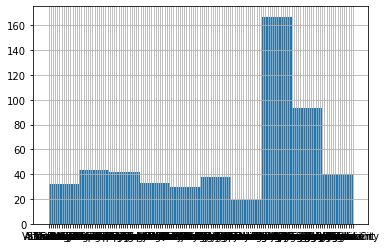

In [27]:
df2["city"].hist()

The last 7 rows are reduntdant in our analysis so we'll remove them

In [13]:
df.loc[df.start_year.isnull(), :].head()

,e,country,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,source1,cost,currency,year,ppp_rate,real_cost,cost_km_millions,source2,reference
119,7376.0,IR,Tehran,Line 6,NaN,2020,0.0,31.00,100.00%,31.00,29.0,Media,90000000.0,IRR,2017.0,0.000064,5760,185.806452,Media,https://financialtribune.com/articles/auto/786...
120,7377.0,IR,Tehran,Line 7,NaN,2019,0.0,27.00,100.00%,27.00,25.0,Media,90000000.0,IRR,2017.0,0.000064,5760,213.333333,Media,https://financialtribune.com/articles/auto/786...
204,7545.0,IN,Nagpur,Phase 2,NaN,NaN,0.0,43.80,0.00%,0.00,32.0,Plan,112160.0,INR,2018.0,0.048000,5383.68,122.915069,Media,https://timesofindia.indiatimes.com/city/nagpu...
271,7712.0,CN,Shenzhen,Line 3 Phase 4,NaN,2022,0.0,9.35,79.36%,7.42,7.0,Plan,10785.0,CNY,2020.0,0.238200,2568.99,274.760000,Plan,https://www.ndrc.gov.cn/xxgk/zcfb/ghwb/201707/...
277,7722.0,CN,Shenzhen,Line 8 Phase 3,NaN,2025,0.0,4.26,100.00%,4.26,NaN,Plan,8318.0,CNY,2020.0,0.238200,1981.35,465.110000,Plan,https://www.ndrc.gov.cn/xxgk/zcfb/ghwb/201707/...


In [14]:
df.loc[df.end_year.isnull(),:]

,e,country,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,source1,cost,currency,year,ppp_rate,real_cost,cost_km_millions,source2,reference
21,7177.0,BG,Sofia,Line 3 extension (Third Stage),2021,NaN,0.0,3.1,100.00%,3.1,4.0,Plan,113.0,EUR,2021.0,3.320,373.5,120.483871,Trade,https://seenews.com/news/sofia-opens-1125-mln-...
153,7442.0,DE,Hamburg,U4 to Dannerallee,2020,NaN,0.0,2.6,100.00%,2.6,3.0,Media,511.0,EUR,2019.0,1.300,664.3,255.500000,Media,https://www.nahverkehrhamburg.de/u4-kann-verla...
174,7483.0,TH,Bangkok,Brown Line,2020,NaN,0.0,22.1,0.00%,0.0,18.0,Plan,48386.0,THB,2020.0,0.081,3919.266,177.342353,Plan,https://www.mrta.co.th/en/projectelectrictrain...
204,7545.0,IN,Nagpur,Phase 2,NaN,NaN,0.0,43.8,0.00%,0.0,32.0,Plan,112160.0,INR,2018.0,0.048,5383.68,122.915069,Media,https://timesofindia.indiatimes.com/city/nagpu...
207,7552.0,IN,Hyderabad,Airport express,2020,NaN,0.0,31.0,8.00%,2.5,10.0,Media,46500.0,INR,2020.0,0.047,2185.5,70.500000,Media,https://www.thehindu.com/news/cities/Hyderabad...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STD,258.744889,NaN,NaN
540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIN,7.789626,NaN,NaN
541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 1,134.863267,215.7812275,NaN
542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 3,241.428571,386.2857143,NaN


In [12]:
df.tail(7)

,e,country,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,source1,cost,currency,year,ppp_rate,real_cost,cost_km_millions,source2,reference
537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12256.983000,NaN,7790.7826,NaN,NaN,NaN,NaN,NaN,NaN,AVG,233.079919,372.9278706,NaN
538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7660.614375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEDIAN,180.702862,289.1245783,NaN
539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STD,258.744889,NaN,NaN
540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIN,7.789626,NaN,NaN
541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 1,134.863267,215.7812275,NaN
542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 3,241.428571,386.2857143,NaN
543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,567.000000,NaN,NaN
